# Revisiting Kaufman's paper

[Lindsey Heagy](http://github.com/lheagy)

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

/Users/lindseyjh/git/python_symlinks/SimPEG/EM/Static/DC/IODC.py:13: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


##  Parameters

### Experiments

From the base example, there are 3 that are setup, you can select one by changing the `experiment` variable or setting your own values for `casing_l`, `sigma_back` and `sigma_air`.

In [2]:
simDir = 'DC_Kaufman'  # create a simulation directory where results can be saved. 

In [3]:
# casing parameters by experiment 
experiments = {
    1: {'casing_l': 2000, 'sigma_back': 1e-2},
}

### select an experiment

In [4]:
experiment = 1

In [5]:
casing_l = experiments[experiment]['casing_l']
sigma_back = experiments[experiment]['sigma_back']

print(
    'Setting up experiment {}. \nThe casing is {}m long, and the '
    'conductivity of the background is {} S/m'.format(
        experiment, casing_l, sigma_back
    )
)

Setting up experiment 1. 
The casing is 2000m long, and the conductivity of the background is 0.01 S/m


In [6]:
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

model = casingSim.model.CasingInWholespace(
    directory = simDir,
    sigma_casing = 1e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., 0., -casing_l/2.],  # put the A electrode just below the surface
    src_b = np.r_[2*casing_l, 0., -casing_l/2.] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
# model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [7]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{u'__class__': 'CasingInWholespace',
 'casing_d': 0.09000000000000001,
 'casing_l': 2000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': u'DC_Kaufman',
 'filename': u'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_back': 0.01,
 'sigma_casing': 1000000.0,
 'sigma_inside': 0.01,
 'src_a': [0.0, 0.0, -1000.0],
 'src_b': [4000.0, 0.0, -1000.0],
 'version': u'0.0.4'}

In [8]:
wholespace = model.copy()
wholespace.sigma_casing = wholespace.sigma_back

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [9]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 0.1  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 29  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
#     hy=0,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

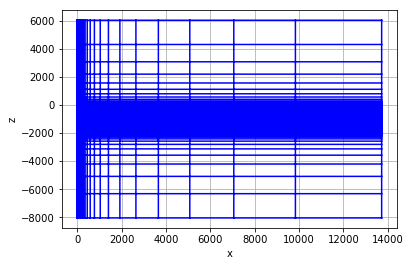

In [10]:
cylMeshGen.mesh.plotGrid()

## Create models to compare to

Here, we create two more models which we want to simulate on
- `solid` fills in the center of the casing with a conductivity equal to that of steel
- `sigma_A` approximates the casing as a solid rod with conductivity found by preserving the conductivity - cross sectional area product. 

In [11]:
# put the models in a dictionary for convienence 
model_names = ['background', 'casing']
modelDict = dict(zip(model_names, [wholespace, model]))

In [12]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(cylMeshGen, mod) 
    for name, mod in modelDict.iteritems()
}

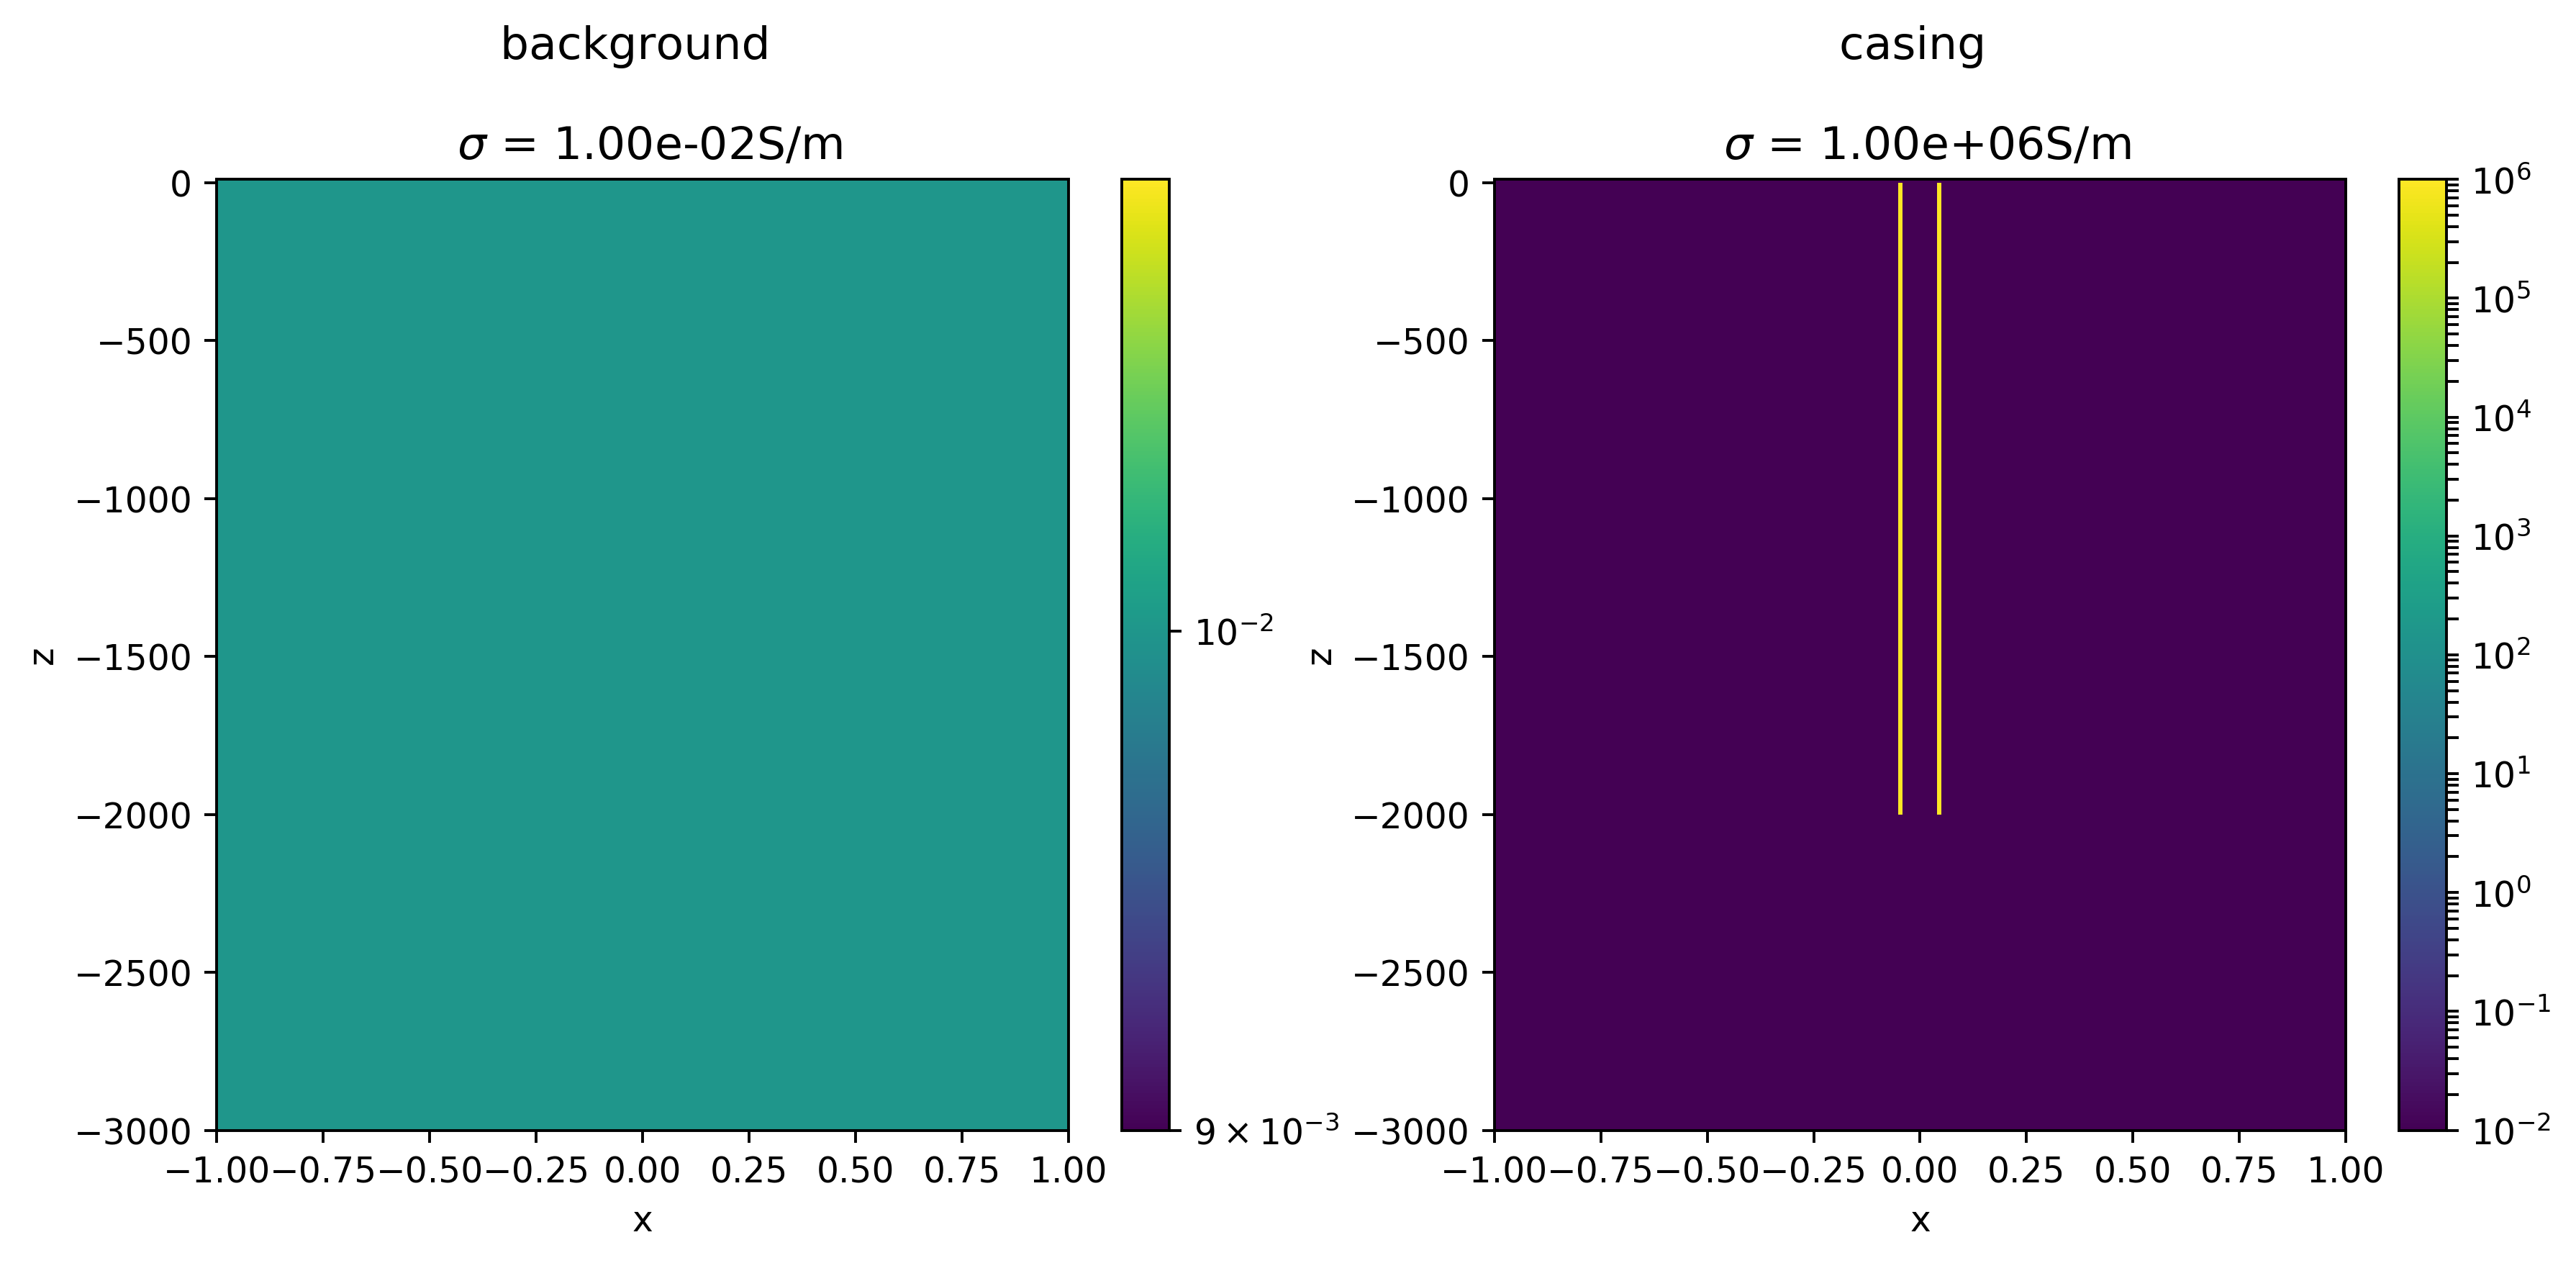

In [13]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*model.casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

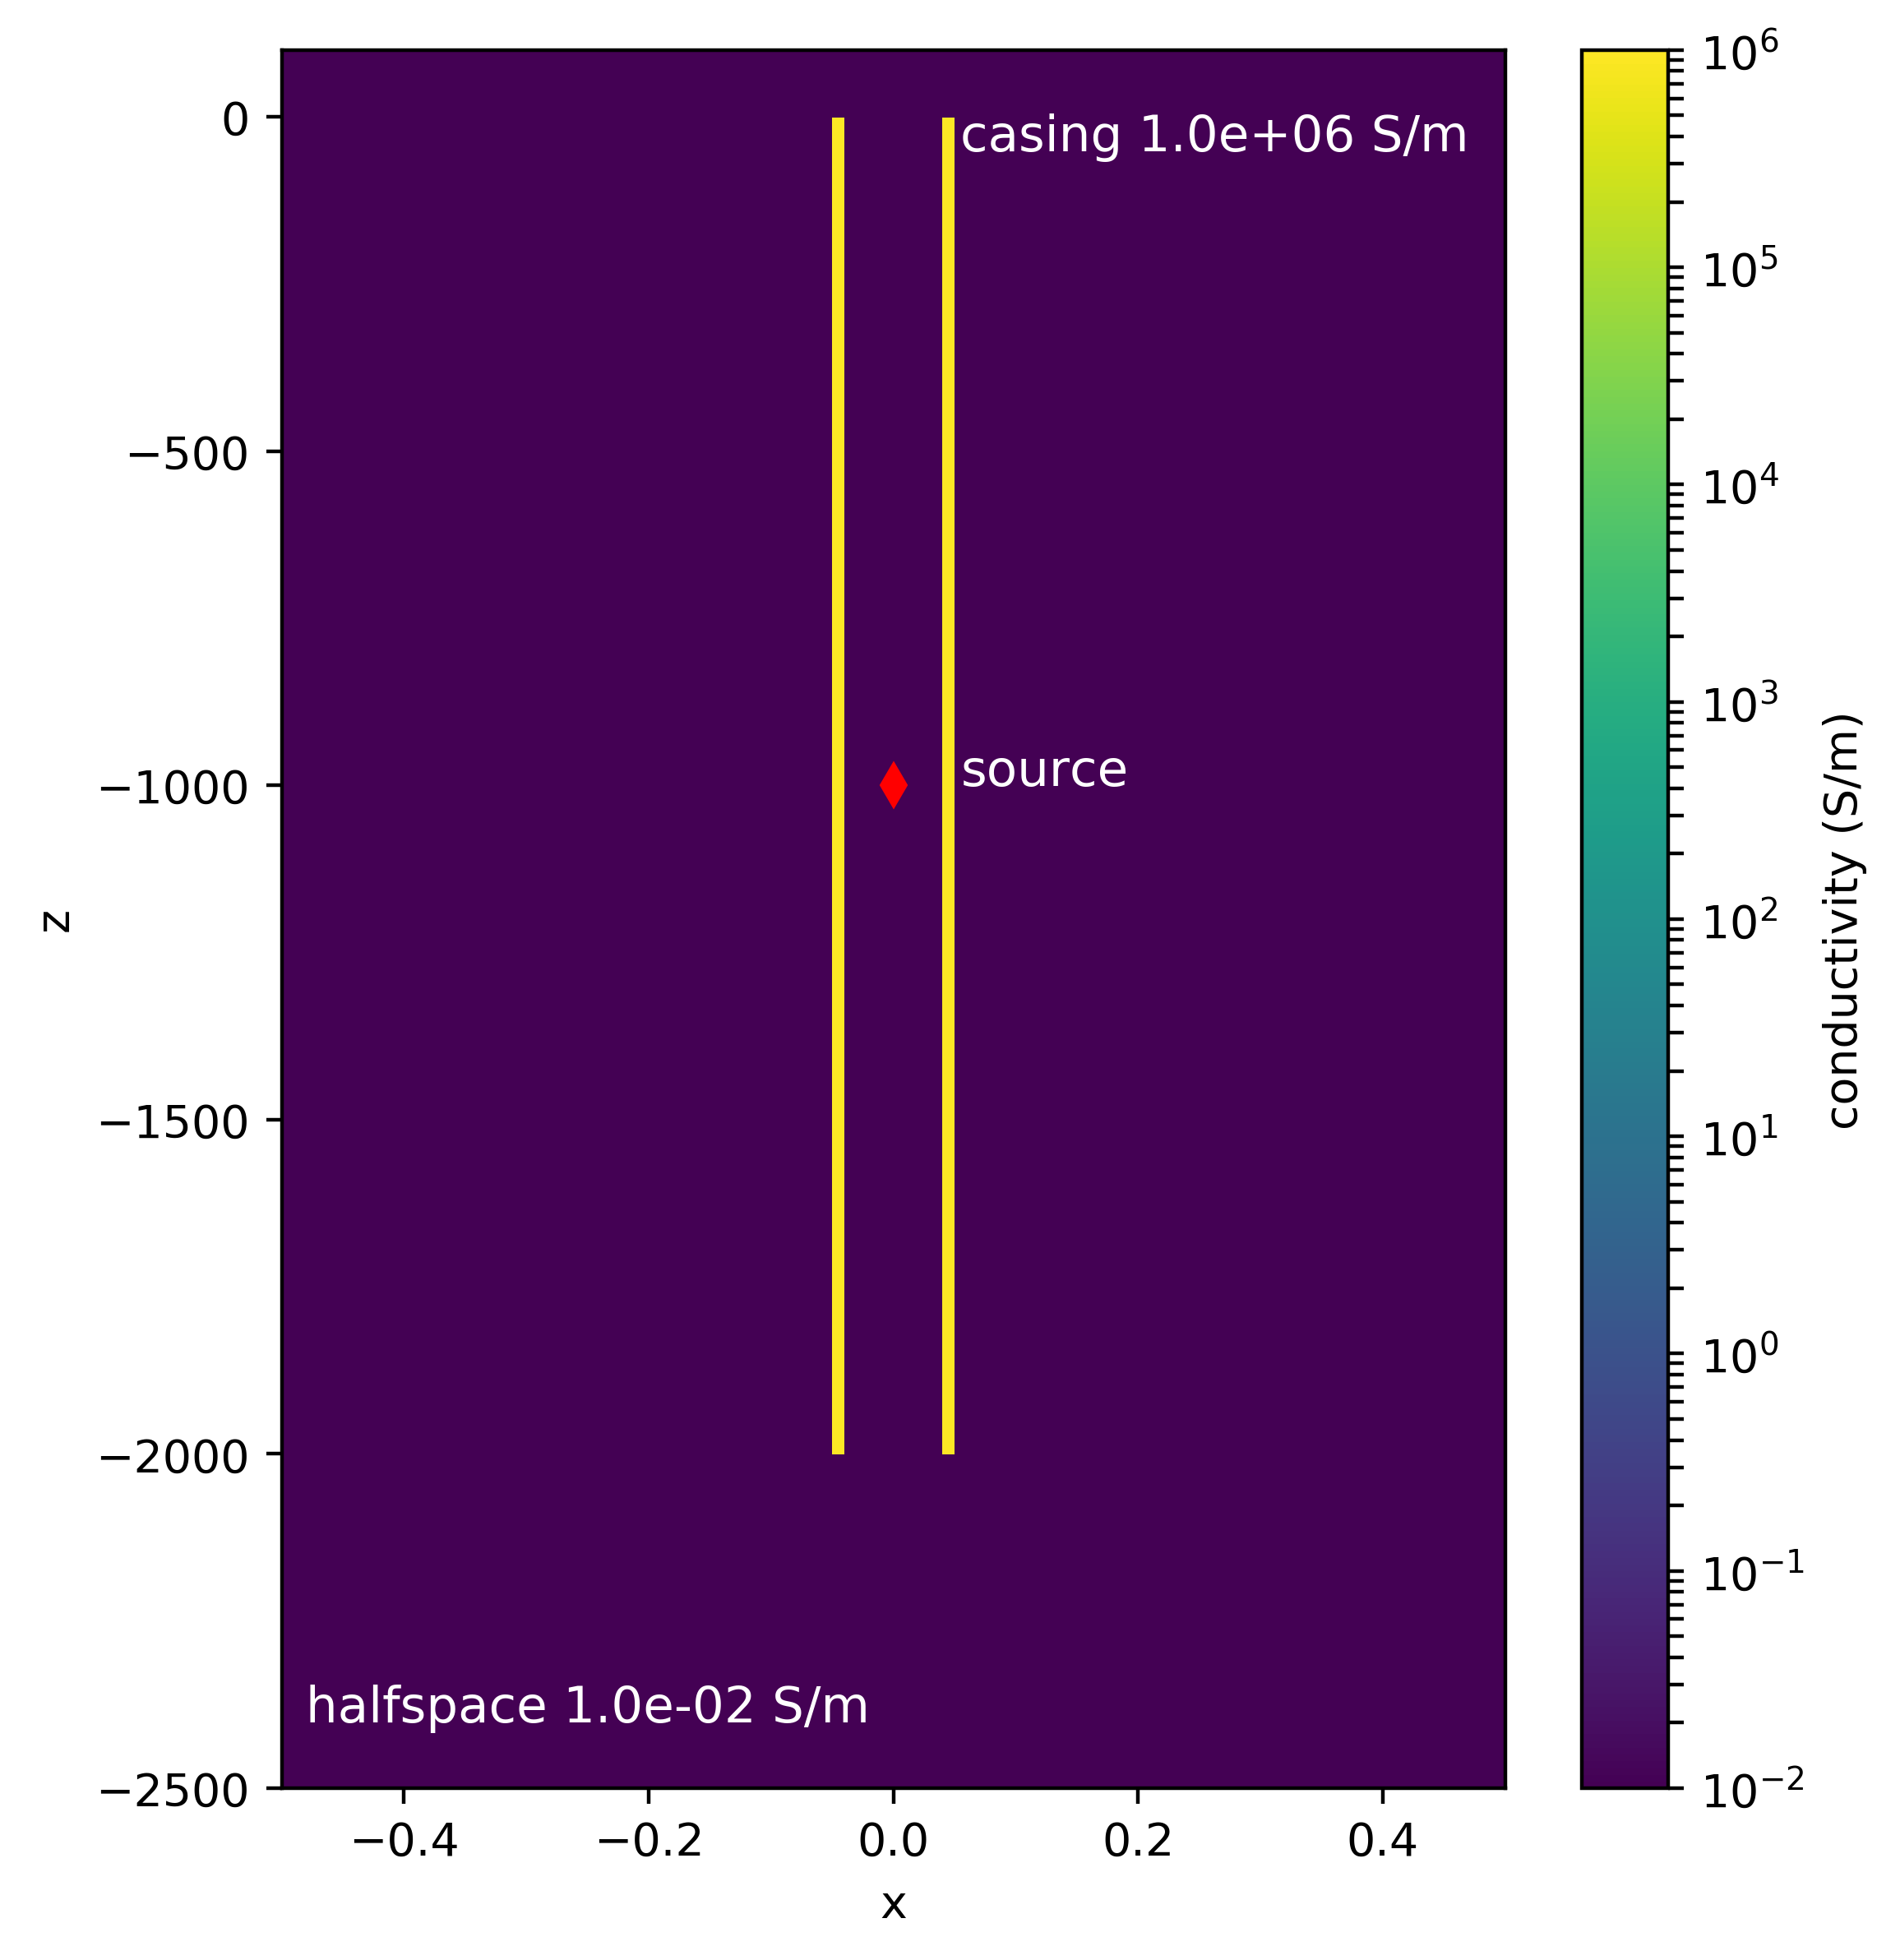

In [14]:
# Plot the source location

symbols = ['rd', 'ws', 'k>', 'mo', 'c*', 'C3s']

fig, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=400)

# cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
ax, cb = physpropsDict['casing'].plot_sigma(
    ax=ax, 
    pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
)

cb.set_label('conductivity (S/m)')

ax.set_title('')

ax.plot(model.src_a[0], model.src_a[2], symbols[0])
ax.plot(model.src_b[0], model.src_b[2], symbols[0])
    
ax.set_xlim(0.5*np.r_[-1, 1]) #src_b[:, 0].max()])
ax.set_ylim([ -1.25*model.casing_l, 100])

xtext = -0.48
# ax.annotate('air {:1.1e} S/m'.format(model.sigma_air), xy=(xtext, 10), color='w', fontsize=11)
ax.annotate('casing {:1.1e} S/m'.format(model.sigma_casing), xy=(0.055, -50), color='w', fontsize=11)
ax.annotate('halfspace {:1.1e} S/m'.format(model.sigma_back), xy=(xtext, -1.2*model.casing_l), color='w', fontsize=11)
ax.annotate(
    'source', xy=(0.055, model.src_a[2]), color='w', fontsize=11, 
)



## set up a DC simulation

In [15]:
simDict = {}
for title in model_names:
    simDict[title] = casingSim.run.SimulationDC(
        modelParameters=modelDict[title], directory=simDir, 
        meshGenerator=cylMeshGen, 
        src_a=modelDict[title].src_a, src_b=modelDict[title].src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [16]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run()
    print('\n')

--- Running background ---
Validating parameters...
      max x: 13724.7083613, min z: -8050.50808887, max z: 6050.50808888, nC: 1525168
Saved DC_Kaufman/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 7.75008320808


--- Running casing ---
Validating parameters...
      max x: 13724.7083613, min z: -8050.50808887, max z: 6050.50808888, nC: 1525168
Saved DC_Kaufman/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 6.88247299194


CPU times: user 19.6 s, sys: 2.53 s, total: 22.1 s
Wall time: 14.7 s


## Plot the casing currents

In [17]:
# plot currents in casing

epsilon = 1e-16
src_ind=0

def plot_casing_currents():
   
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=400)
    ax = [ax]
    
    for i, key in enumerate(model_names):
        f = fieldsDict[key]
        src = simDict[key].survey.srcList[src_ind]
        mod = modelDict[key]
        
        ix, iz = casingSim.physics.CasingCurrents(
            f[src, 'j'], cylMeshGen.mesh, 0, 
#             mod.casing_a if key == 'baseline' else 0, 
            mod.casing_b, mod.casing_z,
        )
        
        ax[0].plot(cylMeshGen.mesh.vectorNz, -iz, label=key, color="C{}".format(i))

    [a.set_xlim([0., -casing_l]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('depth (m)')]
#     ax[0].set_ylabel('Electric Field (V/m)')    

#     ax[1].legend()
#     ax[1].set_ylabel('percent difference')

    ax[0].set_ylabel('Downward-going Current (A)')
    
#     ax[0].set_title(src_names[src_ind] + ' source \n\n Vertical Current in Casing')
    
    
    plt.tight_layout()
    plt.show()

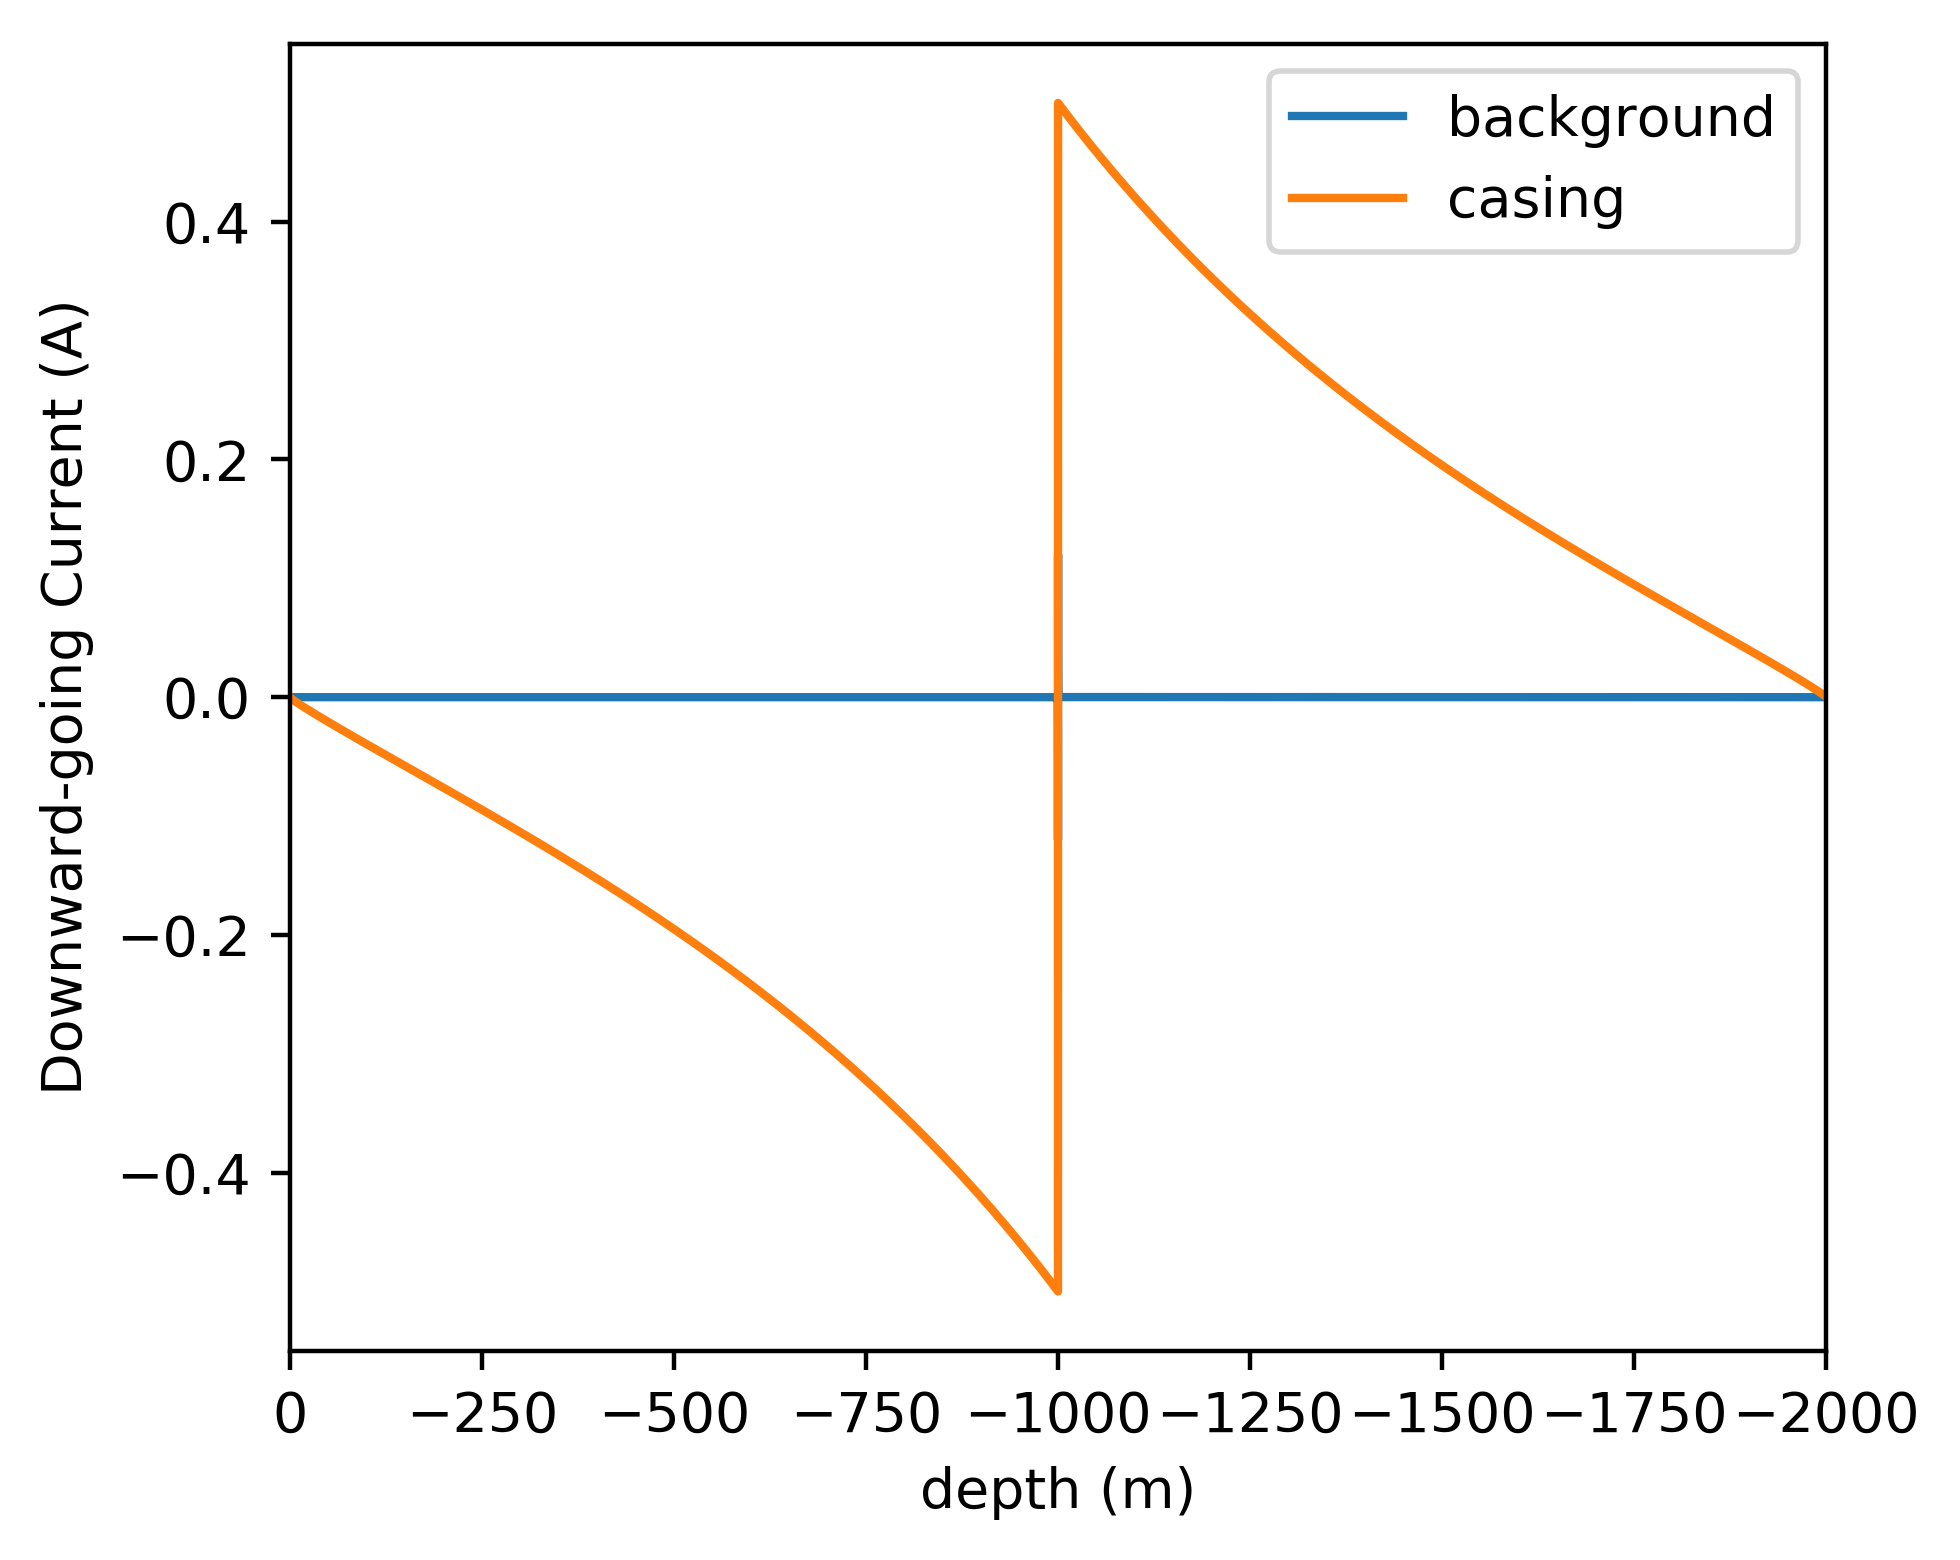

In [18]:
plot_casing_currents()

In [19]:
def horizontal_current_flux(mesh, j, radius=1):
    Fx_inds = np.absolute(mesh.gridFx[:,0] - radius) == np.min(np.absolute(mesh.vectorNx - radius))

    jA = utils.sdiag(mesh.area) * j
    jA_surface = jA[
        np.hstack([Fx_inds, np.zeros(mesh.nFy, dtype=bool), np.zeros(mesh.nFz, dtype=bool)])
    ].reshape(mesh.vnFx[1], mesh.vnFx[2], order='F')

    ix = jA_surface.sum(0)
    
    return ix

In [20]:
# plot currents in casing

epsilon = 1e-16
src_ind=0

def plot_formation_currents(radius=1, ymax=None):

    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=400)
    ax = [ax]
    
    for i, key in enumerate(model_names):
        f = fieldsDict[key]
        src = simDict[key].survey.srcList[src_ind]
        
        ix = horizontal_current_flux(
            cylMeshGen.mesh, fieldsDict[key][src, 'j'], radius
        )
        
        ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=key, color="C{}".format(i))
    
    [a.set_xlim([0., -1.25*casing_l]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('z (m)') for a in ax]
    
    if not ymax is not None or ymax !=0:
        ylim = [0, ymax]
        ax[0].set_ylim(ylim)

    ax[0].set_ylabel('Horizontal currents (A)')
    
    ax[0].set_title('Horizontal Current in Formation, r={}'.format(radius))
    
    
    plt.tight_layout()
    plt.show()

In [21]:
ipywidgets.interact(
    plot_formation_currents,
    radius=ipywidgets.FloatText(value=10),
    ymax=ipywidgets.FloatText(value=0)
)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plot_formation_currents>

## Charges

How do the charges change with different casing models?

In [36]:
# Plot the charges
mesh2D = cylMeshGen.create_2D_mesh().mesh
src_ind=0
theta_ind=0
background_key = 'background'

def plotCasingResults(
    ax = None,
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='charge', model='casing', 
    primsec=['total', 'primary', 'secondary'], 
    casing_outline=True
):
    if ax is None: 
        plt.subplots(1, 1, figsize=(5, 6))
        
    assert view.lower() in ['charge', 'phi', 'j', 'e']

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
    }
    
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim

        if clim_min is not None or clim_min != 0.:
            plotopts['clim'][0] = clim_min
        
    if primsec == 'primary':
        model = background_key

    pp = physpropsDict[model]
    src = simDict[model].survey.srcList[src_ind]
    plotme = simDict[model].fields()[src, view]
    
    if primsec == 'secondary':
        prim_src = simDict[background_key].survey.srcList[src_ind]
        plotme = plotme - simDict[background_key].fields()[prim_src, view]

    if view in ['charge', 'phi']:
        _, cb = pp.plot_prop(
            plotme,
            ax=ax,
            pcolorOpts = {'cmap': 'bwr' if view == 'charge' else 'viridis'},
            **plotopts 
        )
    elif view in ['j', 'e']:
        jplt = casingSim.face3DthetaSlice(
            cylMeshGen.mesh, plotme, theta_ind=theta_ind
        )
        _, cb = casingSim.plotFace2D(
            mesh2D,
            jplt, real_or_imag='real', ax=ax, range_x=xlim,
            range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            logScale=True, clim=clim, mirror=True
        )
    ax.set_title('{} {}'.format(primsec, view), fontsize=13)
    #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#         cb.set_label(view)
        
    # plot outline of casing
    if casing_outline is True: 
        m = modelDict[model]
        factor = [-1, 1]
        [
            ax.plot(
                fact * np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
                np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
                'k', 
                lw = 0.5
            ) 
            for fact in factor
        ]
    return ax 
    

def plotCasingResultsWidget(
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='charge', model='all', 
    primsec=['total', 'primary', 'secondary']
):
    
    model_names = model_names if model == 'all' else [model]
    
    fig, ax = plt.subplots(1, len(model_names), figsize=(len(model_names)*5, 6))
    if len(model_names) == 1:
        ax = [ax]
    
    for a, mod in zip(ax, model_names): 
        a = plotCasingResults(
            ax = a,
            clim_max=clim_max, clim_min=clim_min, 
            max_depth=max_depth, 
            max_r=max_r, top=top, view=view, model=mod, 
            primsec=primsec, 
            casing_outline=True
        )
    
    plt.tight_layout()
    plt.show()

### Widget for viewing Results

The widgets available to you are
- **theta_ind**: [0, ntheta slices] Which azimuth should we slice through
- **clim_max**: max value on the colorbar so you can saturate it
- **max_depth**: max z-limit for the plot
- **top**: top of the plot (z)

observations:
- (sanity checks): in all charges at interface between casing and formation. All positive charges (positive electrode connected to casing
- charge distribution more uniform along length of casing for solid steel (also makes sense: better conductor)

<function __main__.plotCasingResultsWidget>

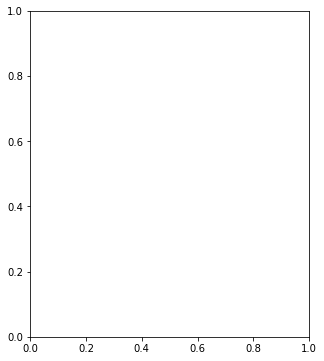

In [38]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

ipywidgets.interact(
    plotCasingResultsWidget,
    clim_max = ipywidgets.FloatText(value=0),
    clim_min = ipywidgets.FloatText(value=0),
    max_depth = ipywidgets.FloatText(value=1025), 
    max_r = ipywidgets.FloatText(value=0.1),
    top = ipywidgets.FloatText(value=-975),
    view = ipywidgets.ToggleButtons(
        options=['charge', 'phi', 'j', 'e'], value='charge'
    ),
    model = ipywidgets.ToggleButtons(
        options=model_names + ['all'], value='casing'
    ),
    primsec = ipywidgets.ToggleButtons(
        options=['total', 'primary', 'secondary'], value='total'
    )
)   

In [24]:
# Plot the models

def plotScalarDifference(
    clim_max=None, theta_ind=0, src_ind=0, max_depth=1.1*model.casing_l, max_r=0.1, top=10.,  view='charge', 
):
    assert view in ['charge', 'phi']
        
    fig, ax = plt.subplots(1, len(model_names)-1, figsize=(5*(len(model_names)-1), 5))
    
    xlim = max_r*np.r_[0, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    src_baseline = simDict['baseline'].survey.srcList[src_ind]
    
    for a, title in zip(ax, ['solid', 'sigma_A']):
        pp = physpropsDict[title]
        src = simDict[title].survey.srcList[src_ind]
        plotme = simDict[title].fields()[src, view] - simDict['baseline'].fields()[src_baseline, view]
        
        if clim_max is None or clim_max == 0.:
            clim = np.absolute(plotme).max() * np.r_[-1., 1.]
        else: 
            clim = clim_max * np.r_[-1, 1]
        
        _, cb = pp.plot_prop(
            plotme,
            ax=a,
            pcolorOpts={
                'cmap': 'bwr' if view == 'charge' else 'viridis',
            },
            clim=clim,
            theta_ind=theta_ind
        )
        a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m\ntheta = {:1.2f} degree'.format(
            title, pp.modelParameters.sigma_casing, cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi
        ), fontsize=13)
    #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
        a.set_xlim(xlim)
        a.set_ylim(zlim)
        cb.set_label('secondary ' + view)
        
        # plot outline of casing
        m = modelDict[title]
        a.plot(
            np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
            np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
            'k' if view == 'charge' else 'w', 
            lw = 0.5
        )
    
    plt.tight_layout()
    plt.show()

### Plot the difference in charge distributions (approximation - true) 

observations: 
- first: colorbar scales are different between the two! 
- solid steel: more negative at top, positive at bottom (consistent with more uniform charge distribution) 

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plotScalarDifference>

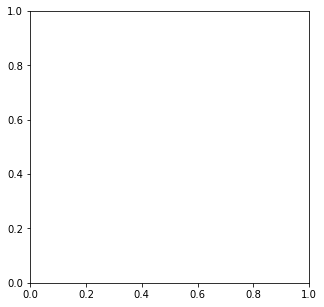

In [25]:
ipywidgets.interact(
    plotScalarDifference,
    theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=1),
    clim_max = ipywidgets.FloatText(value=0), 
    max_depth = ipywidgets.FloatText(value=1.25*model.casing_l), 
    max_r = ipywidgets.FloatText(value=0.1),
    top = ipywidgets.FloatText(value=10),
    view = ipywidgets.ToggleButtons(options=['charge', 'phi'], value='charge'), 
)

### Total charge on the casing

- integrate the charge on the casing. 

In [26]:
casing_charge = {}
for title in model_names:
    casing_charge[title] = (
        utils.mkvc(simDict[title].fields()[simDict[title].survey.srcList[src_ind], 'charge'])
    )[modelDict[title].ind_casing(cylMeshGen.mesh)].sum()
    print('{:8s}: {:1.3e}'.format(title, casing_charge[title]))

background: 9.804e-23
casing  : 2.490e-11


In [27]:
print(np.finfo(float).eps)

2.22044604925e-16
